In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns


In [32]:
features = pd.read_csv('data/features.csv')
stores = pd.read_csv('data/stores.csv')
sales = pd.read_csv('data/sales.csv')
# I renamed the csv files to make them easier to work with

In [33]:
def quickDescribe(df): # I made this function to quickly describe the data since we are working with 3 data sets
    print('\n', '##Example##\n' , df.head(1))
    print('\n', '##stats##\n', df.describe())
    print('\n', '##datatypes##\n', df.info()) # for some reason the ##datatype## is below the the df.info output?
    print('\n', '##nulls##\n' , df.isnull().sum())
quickDescribe(features)


 ##Example##
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  

 ##stats##
              Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.9800

In [34]:
## Cleaning the features data set
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True) # Confirmed that the dates are in the correct format

In [35]:
missing_CPI_Dates = features['Date'].loc[features['CPI'].isnull()]
missing_CPI_Dates.groupby(missing_CPI_Dates.dt.year).count() # I grouped the missing CPI dates by year to see if there was a pattern

Date
2013    585
Name: Date, dtype: int64

In [36]:
# Seeing as the miscosg values are all from 2013, I will fill them with the mean of the column
# features['CPI'] = features['CPI'].fillna(features['CPI'].mean())
# # I will do the same for the unemployment column
# features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].mean())
# Since they are both from 2013, we may end up dropping the whole year from the data set
features = features.dropna() # I decided to drop the whole year since it is only 3 rows of data
sales = sales.dropna() # I decided to drop the whole year since it is only 3 rows of data



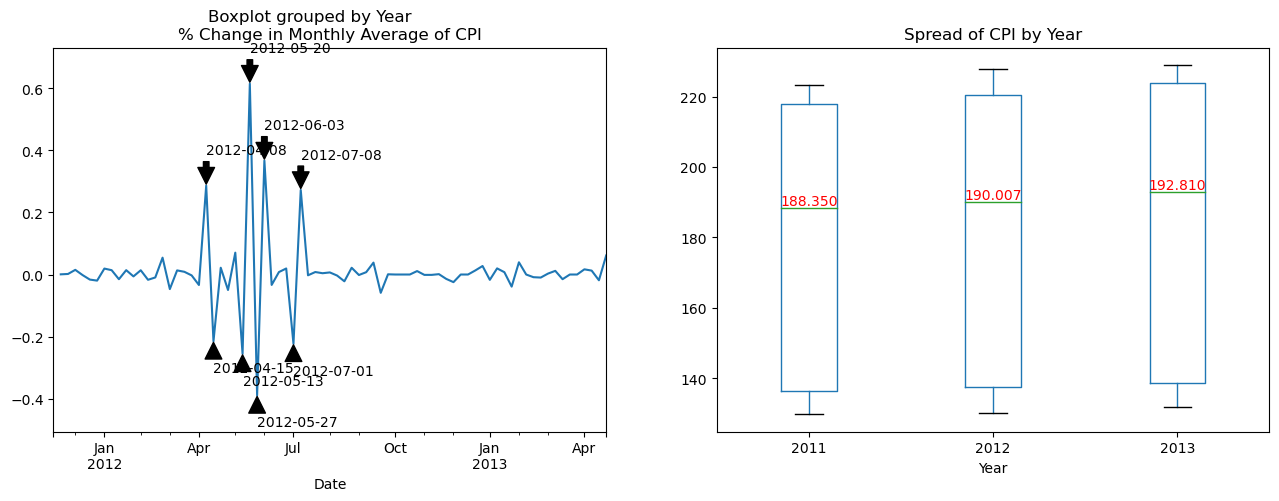

In [37]:
fig, axs = plt.subplots(1,2)

droppedFeatures = features.dropna()
cpi = droppedFeatures['CPI']
cpi_dates = droppedFeatures['Date']

graphDF = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
graphDF = graphDF.set_index('Date')

groupedChange = graphDF.groupby(pd.Grouper(freq="W")).mean().pct_change()
groupedChange

grouped_data = graphDF.groupby(graphDF.index.year)



fig1 = groupedChange.plot(kind='line',
                           ylim=(groupedChange['CPI'].min() - groupedChange['CPI'].std(), groupedChange['CPI'].max() + groupedChange['CPI'].std()),
                             ax=axs[0], title='% Change in Monthly Average of CPI', legend=False)

#set an annotation of the date if the change is greater than 0.1
for i in range(len(groupedChange)):
    if groupedChange.iloc[i]['CPI'] > 0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
    if groupedChange.iloc[i]['CPI'] < -0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] - 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
        
    

df = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
df['Date'] = pd.to_datetime(df['Date']).dt.year
df.rename(columns={'Date': 'Year'}, inplace=True)
fig2 = df.boxplot(by='Year', column='CPI', figsize=(12,8), ax=axs[1], grid=False)
fig2.set_title('Spread of CPI by Year')

## setting label
i = 0
for year in df['Year'].unique():
  median_value = df['CPI'].loc[df['Year'] == year].median()
  text_x = fig2.get_xticks()[i]
  text_y = median_value
  i += 1
  axs[1].text(text_x, text_y, f'{median_value:.3f}', color='r', ha='center', va='bottom')

plt.subplots_adjust(bottom=0.1, right=2,)
plt.show()

# Thanks to:
# https://stackoverflow.com/a/16393023 
# https://stackoverflow.com/a/45229527

In [38]:
graphDF.groupby(pd.Grouper(freq="W")).mean()

,CPI
Date,
2011-11-13,173.351485
2011-11-20,173.448716
2011-11-27,173.754923
2011-12-04,176.365775
2011-12-11,176.050928
...,...
2013-03-31,NaN
2013-04-07,178.042293
2013-04-14,180.283166


In [49]:
from datetime import datetime
sales['Date'] = [datetime.strptime(date, '%d/%m/%Y') for date in sales['Date']] # I converted the date column to datetime format
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [50]:
may2012 = sales.loc[sales['Date'].dt.year == 2012].loc[sales['Date'].dt.month == 5]
june2012 = sales.loc[sales['Date'].dt.year == 2012].loc[sales['Date'].dt.month == 6]
potential_outliers = pandas.concat([may2012, june2012])


In [51]:
quickDescribe(potential_outliers)


 ##Example##
      Store  Dept       Date  Weekly_Sales  IsHoliday
117      1     1 2012-05-04      17147.44      False

 ##stats##
               Store          Dept   Weekly_Sales
count  26575.000000  26575.000000   26575.000000
mean      22.268109     44.522220   16157.170602
std       12.790266     30.634542   22154.073639
min        1.000000      1.000000    -548.000000
25%       11.000000     18.000000    2097.275000
50%       22.000000     38.000000    7622.190000
75%       33.000000     74.000000   21038.935000
max       45.000000     99.000000  206575.900000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26575 entries, 117 to 421552
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         26575 non-null  int64         
 1   Dept          26575 non-null  int64         
 2   Date          26575 non-null  datetime64[ns]
 3   Weekly_Sales  26575 non-null  float64       
 4   IsHoliday

In [52]:
salesViZ = sales
salesViZ['Date'] = pandas.to_datetime(salesViZ['Date'])


In [71]:
def is_pre_holiday(date):
    for key, value in timeDict.items():
        # Check if the date falls within the same week as the holiday
        if date > value and date < key:
            return True
    return False


In [72]:
holidays = salesViZ[salesViZ['IsHoliday'] == True]
holiday_dates = holidays['Date'].unique()
high_priority_dates = []
for date in holiday_dates:
    four_weeks_before_holiday = date - pd.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
    
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)

salesViZ['pre_holiday'] = salesViZ['Date'].apply(is_pre_holiday)
salesViZ.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday
1,1,1,2010-02-12,46039.49,True,False,Holiday
2,1,1,2010-02-19,41595.55,False,False,Non-Holiday
3,1,1,2010-02-26,19403.54,False,False,Non-Holiday
4,1,1,2010-03-05,21827.90,False,False,Non-Holiday


In [73]:
salesViZ['Holiday_Status'] = ''

# Set the holiday status based on the encoded values
salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Pre-Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Non-Holiday'

# salesViZ.drop('pre_holiday', axis=1, inplace=True)
# salesViZ.drop('IsHoliday', axis=1, inplace=True)
salesViZ.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday
1,1,1,2010-02-12,46039.49,True,False,Holiday
2,1,1,2010-02-19,41595.55,False,False,Non-Holiday
3,1,1,2010-02-26,19403.54,False,False,Non-Holiday
4,1,1,2010-03-05,21827.90,False,False,Non-Holiday


In [94]:
weeklysales = salesViZ.groupby(['Date', 'Holiday_Status']).sum()['Weekly_Sales'].reset_index()
weeklysales.head()

,Date,Holiday_Status,Weekly_Sales
0,2010-02-05,Pre-Holiday,49750740.50
1,2010-02-12,Holiday,48336677.63
2,2010-02-19,Non-Holiday,48276993.78
3,2010-02-26,Non-Holiday,43968571.13
4,2010-03-05,Non-Holiday,46871470.30


In [101]:
weeklysales.head()
pivotsales = weeklysales.pivot(index='Date', columns='Holiday_Status', values='Weekly_Sales')
pivotsales.head()

Holiday_Status,Holiday,Non-Holiday,Pre-Holiday
Date,,,
2010-02-05,NaN,NaN,49750740.5
2010-02-12,48336677.63,NaN,NaN
2010-02-19,NaN,48276993.78,NaN
2010-02-26,NaN,43968571.13,NaN
2010-03-05,NaN,46871470.30,NaN


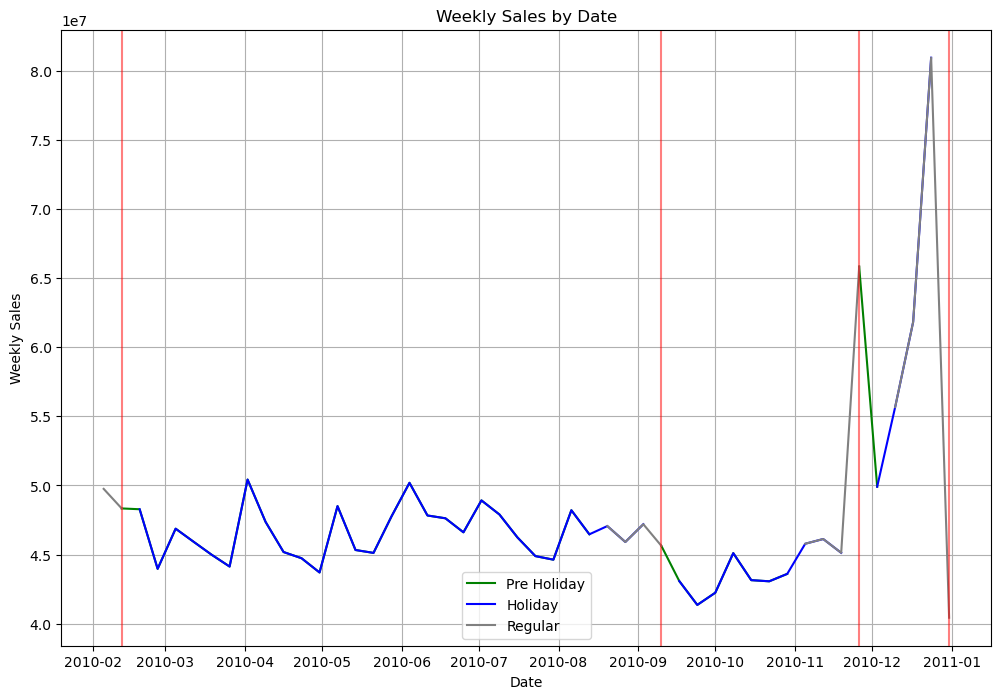

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))

oneYear = weeklysales.loc[weeklysales['Date'].dt.year == 2010]

pholiday = np.ma.masked_where(oneYear['Holiday_Status'] == 'Pre-Holiday', oneYear['Weekly_Sales'])
holiday = np.ma.masked_where(oneYear['Holiday_Status'] == 'Holiday', oneYear['Weekly_Sales'])
regular = np.ma.masked_where(oneYear['Holiday_Status'] == 'Non-Holiday', oneYear['Weekly_Sales'])

ax.plot(oneYear['Date'], pholiday, color='Green', label='Pre Holiday')
ax.plot(oneYear['Date'], holiday, color='blue', label='Holiday')
ax.plot(oneYear['Date'], regular, color='grey', label='Regular')

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.set_title('Weekly Sales by Date')
ax.grid(True)
# annotation with holiday dates
for date in holiday_dates:
    if pd.to_datetime([date]).year == 2010:
        ax.axvline(date, color='red', alpha=0.5)
ax.legend()


plt.show()


In [109]:
oneYear = pivotsales.loc[pivotsales.index.year == 2012]


<Axes: xlabel='Date'>

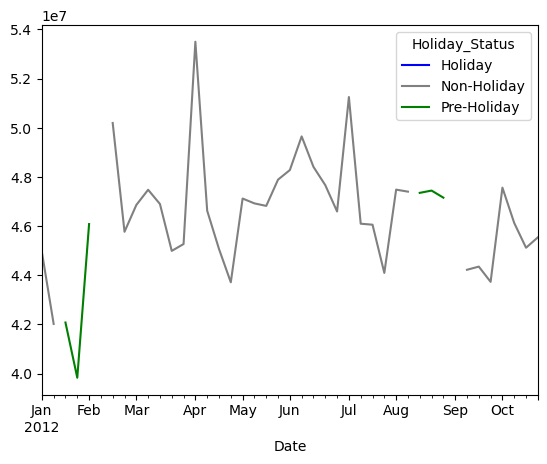

In [112]:
colors_map = {
    'Holiday': 'blue',
    'Pre-Holiday': 'green',
    'Non-Holiday': 'grey'
}
oneYear.plot(color=colors_map)



In [132]:
potential_outliers['IsHoliday'].value_counts() # I checked to see if there were any holidays during this time


False    26575
Name: IsHoliday, dtype: int64

In [133]:
sales_cleaned = sales.loc[sales['Date'].dt.year != 2012].loc[sales['Date'].dt.month != 5].loc[sales['Date'].dt.month != 6]  # TODO replace with mean of the same week in the previous year
features_cleaned = features.loc[features['Date'].dt.year != 2012].loc[features['Date'].dt.month != 5].loc[features['Date'].dt.month != 6] # TODO replace  with mean of the same week in the previous year
features_cleaned['CPI'].fillna(features_cleaned['CPI'].mean(), inplace=True) # I filled the missing values with the mean

In [134]:
# lets join the features and sales data sets on the store and date columns
sales_features = pandas.merge(sales_cleaned, features_cleaned, on=['Store', 'Date'], how='inner')
sales_features.info() # I checked to see if the merge was successful

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247256 entries, 0 to 247255
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           247256 non-null  int64         
 1   Dept            247256 non-null  int64         
 2   Date            247256 non-null  datetime64[ns]
 3   Weekly_Sales    247256 non-null  float64       
 4   IsHoliday_x     247256 non-null  bool          
 5   pre_holiday     247256 non-null  bool          
 6   Holiday_Status  247256 non-null  object        
 7   Temperature     247256 non-null  float64       
 8   Fuel_Price      247256 non-null  float64       
 9   MarkDown1       23700 non-null   float64       
 10  MarkDown2       20154 non-null   float64       
 11  MarkDown3       23116 non-null   float64       
 12  MarkDown4       21042 non-null   float64       
 13  MarkDown5       23994 non-null   float64       
 14  CPI             247256 non-null  flo

In [135]:
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [136]:
#cosce we are going to do some predictions on the sales data, we need to encode the categorical data
sales_features['IsHoliday_x'] = sales_features['IsHoliday_x'].astype(int) # I converted the IsHoliday column to int
sales_features.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True) # I renamed the IsHoliday_x column to IsHoliday
sales_features.drop(columns=['IsHoliday_y'], inplace=True) # I dropped the IsHoliday_y column
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [137]:
#Correct me if im wrong here, but markdown NaN can be replaced with 0 since markdown is a discount and 0 is no discount
sales_features['MarkDown1'].fillna(0, inplace=True)
for i in range(1,6):
    sales_features['MarkDown'+ str(i)].fillna(0, inplace=True)

sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [138]:
# adding the tag "is_pre_holiday"  if the date is 4 weeks before a holiday


In [139]:
holidays = sales_features[sales_features['IsHoliday'] == True]

In [140]:
holiday_dates = holidays['Date'].unique()
holiday_dates

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [141]:
high_priority_dates = []
for date in holiday_dates:
    four_weeks_before_holiday = date - pandas.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
print(high_priority_dates)
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)


[numpy.datetime64('2010-01-15T00:00:00.000000'), numpy.datetime64('2010-08-13T00:00:00.000000'), numpy.datetime64('2010-10-29T00:00:00.000000'), numpy.datetime64('2010-12-03T00:00:00.000000'), numpy.datetime64('2011-01-14T00:00:00.000000'), numpy.datetime64('2011-08-12T00:00:00.000000'), numpy.datetime64('2011-10-28T00:00:00.000000'), numpy.datetime64('2011-12-02T00:00:00.000000')]


In [142]:
def is_pre_holiday(date):
    for key, value in timeDict.items():
        if date >= value and date <= key:
            return 1
    return 0


In [143]:
sales_features['pre_holiday'] = sales_features['Date'].apply(is_pre_holiday)
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [144]:
#splitting the date into year, month, and day columns
sales_features['Year'] = sales_features['Date'].dt.year
sales_features['Month'] = sales_features['Date'].dt.month
sales_features['Day'] = sales_features['Date'].dt.day
sales_features.drop(columns=['Date'], inplace=True)
sales_features.head()


,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5


In [145]:
# encoding the year into 1, 2, 3, 4
sales_features['Year'] = sales_features['Year'].map({2010: 1, 2011: 2, 2012: 3, 2013: 4})
sales_features.head()

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5


In [147]:
# Encoding the month and days cyclically thanks to http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
# Basicly, we are ploting the month and day onto a "clock" and then using the angle of the clock hand to encode the month and day between -1 and 1 
sales_features['mnth_sin'] = np.sin((sales_features.Month-1)*(2.*np.pi/12))
sales_features['mnth_cos'] = np.cos((sales_features.Month-1)*(2.*np.pi/12))

In [148]:
def day_sin(row):
    if row['Month'] == 1:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.sin((row['Day']-1)*(2.*np.pi/28))
    elif row['Month'] == 3:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [149]:
def day_cos(row):   
    if row['Month'] == 1:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.cos((row['Day']-1)*(2.*np.pi/28)) 
    elif row['Month'] == 3:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [150]:
sales_features['day_sin'] = sales_features.apply(day_sin, axis=1)
sales_features['day_cos'] = sales_features.apply(day_cos, axis=1) 

In [151]:
sales_features.drop(columns=['Month', 'Day'], inplace=True)
sales_features.head()

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,mnth_sin,mnth_cos,day_sin,day_cos
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0.5,0.866025,0.781831,0.62349
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0.5,0.866025,0.781831,0.62349
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0.5,0.866025,0.781831,0.62349
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0.5,0.866025,0.781831,0.62349
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0.5,0.866025,0.781831,0.62349


In [156]:
#dropping our holiday_status column since that was for human readability
sales_features.drop(columns=['Holiday_Status'], inplace=True)

In [152]:
#one hot encoding the store, department numbers
sales_features = pandas.get_dummies(sales_features, columns=['Store', 'Dept'])
sales_features.head()

,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
#printing off the columns to make sure everything is good
for col in sales_features.columns:
    print(col)

Weekly_Sales
IsHoliday
pre_holiday
Holiday_Status
Temperature
Fuel_Price
MarkDown1
MarkDown2
MarkDown3
MarkDown4
MarkDown5
CPI
Unemployment
Year
mnth_sin
mnth_cos
day_sin
day_cos
Store_1
Store_2
Store_3
Store_4
Store_5
Store_6
Store_7
Store_8
Store_9
Store_10
Store_11
Store_12
Store_13
Store_14
Store_15
Store_16
Store_17
Store_18
Store_19
Store_20
Store_21
Store_22
Store_23
Store_24
Store_25
Store_26
Store_27
Store_28
Store_29
Store_30
Store_31
Store_32
Store_33
Store_34
Store_35
Store_36
Store_37
Store_38
Store_39
Store_40
Store_41
Store_42
Store_43
Store_44
Store_45
Dept_1
Dept_2
Dept_3
Dept_4
Dept_5
Dept_6
Dept_7
Dept_8
Dept_9
Dept_10
Dept_11
Dept_12
Dept_13
Dept_14
Dept_16
Dept_17
Dept_18
Dept_19
Dept_20
Dept_21
Dept_22
Dept_23
Dept_24
Dept_25
Dept_26
Dept_27
Dept_28
Dept_29
Dept_30
Dept_31
Dept_32
Dept_33
Dept_34
Dept_35
Dept_36
Dept_37
Dept_38
Dept_39
Dept_40
Dept_41
Dept_42
Dept_43
Dept_44
Dept_45
Dept_46
Dept_47
Dept_48
Dept_49
Dept_50
Dept_51
Dept_52
Dept_54
Dept_55
Dept_56
De

In [154]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [157]:
y = sales_features['Weekly_Sales']
X = sales_features.drop(columns=['Weekly_Sales'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("R-squared score:", accuracy)

R-squared score: 0.642356180099321


In [161]:
# Create a dataframe of the model coefficients
coef = pandas.DataFrame(list(zip(X.columns, model.coef_)), columns=['Features', 'Coefficients'])
coef

,Features,Coefficients
0,IsHoliday,-1.202660e+02
1,pre_holiday,6.446652e+02
2,Temperature,-2.371264e+02
3,Fuel_Price,6.596051e+02
4,MarkDown1,1.968378e+01
...,...,...
137,Dept_95,1.130661e+15
138,Dept_96,9.709343e+14
139,Dept_97,1.116431e+15
140,Dept_98,1.074871e+15


In [160]:
#create a dataframe of the model feature importances
importances = pandas.DataFrame(list(zip(X.columns, np.transpose(model.coef_))), columns=['Features', 'Importance'])
importances.sort_values(by=['Importance'], ascending=False, inplace=True)
importances.head(10)

,Features,Importance
134,Dept_92,1.130661e+15
137,Dept_95,1.130661e+15
97,Dept_38,1.130661e+15
132,Dept_90,1.130661e+15
99,Dept_40,1.130661e+15
62,Dept_2,1.130661e+15
133,Dept_91,1.130661e+15
73,Dept_13,1.130661e+15
68,Dept_8,1.130661e+15
67,Dept_7,1.130661e+15


In [81]:
#dig into the mnth_sin feature, can we determine what month is the best for sales?



-5.000000e-01    29802
 1.000000e+00    29443
 1.224647e-16    29182
-1.000000e+00    26487
-8.660254e-01    26485
-8.660254e-01    23613
 8.660254e-01    23601
 5.000000e-01    23580
-5.000000e-01    23368
 0.000000e+00    11695
Name: mnth_sin, dtype: int64

Low R-Squared Score, we are looking for at least a .7, more like .9 so lets try other stuff

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import threading
import time

# Define a function for model training with a timeout
def train_model_with_timeout(pipeline, X, y, max_training_time):
    def train_model():
        pipeline.fit(X, y)

    thread = threading.Thread(target=train_model)
    thread.daemon = True
    thread.start()
    thread.join(max_training_time)

    if thread.is_alive():
        # If the training is still running, stop the pipeline and raise a TimeoutError
        pipeline.named_steps['regressor'].n_jobs = 1  # Set n_jobs to 1 for thread safety
        pipeline.named_steps['regressor'].n_estimators = 0  # Stop training by setting n_estimators to 0
        thread.join()
        raise TimeoutError("Training time exceeded the threshold.")

# Create a pipeline with scaling and Random Forest Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, n_jobs=-1))  # Adjust n_estimators and n_jobs as needed
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the maximum training time threshold (in seconds)
max_training_time = 5  # 5 minutes

# Start the timer
start_time = time.time()

try:
    # Train the model with timeout
    train_model_with_timeout(pipeline, X_train, y_train, max_training_time)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the accuracy of the prediction using R-squared score
    accuracy = r2_score(y_test, y_pred)
    print("R-squared score:", accuracy)

except TimeoutError:
    print("Training time exceeded the threshold. Skipping the prediction.")


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regression model
model = RandomForestRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Random Forest R-squared score:", accuracy)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regression model
model = GradientBoostingRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Gradient Boosting R-squared score:", accuracy)


In [ ]:
from sklearn.svm import SVR

# Create a Support Vector Regression model
model = SVR()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Support Vector Regression R-squared score:", accuracy)
